# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grids
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import inflection
import datetime
import random
import pickle
import json
import requests
from flask import Flask
import xgboost as xgb
from boruta import BorutaPy
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import metrics as mt
from scipy import stats as ss
from tabulate import tabulate
from IPython.display import Image
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def ml_error(model_name, testy, haty):
    mae = mt.mean_absolute_error(testy, haty)
    mape = mt.mean_absolute_percentage_error(testy, haty)
    rmse = np.sqrt(mt.mean_squared_error(testy, haty))
                   
    return pd.DataFrame({'Model_Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def mean_percentage_error(y, yhat):
    mpe = np.mean((y-yhat)/y)
    return mpe

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list =[]

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('KFold number: {}'.format(k))
            
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=7*6*k)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=7*6*(k-1))

        #filtering dataset
        training_date = x_training['date'] < validation_start_date
        training = x_training.loc[training_date, :]

        valid_date = (x_training['date'] >= validation_start_date) & (x_training['date'] < validation_end_date)
        validation = x_training.loc[valid_date, :]

        #training and validation dataset 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model -
        m = model
        m.fit(xtraining, ytraining)
        yhat = m.predict(xvalidation)

        m_result = ml_error("Modelo", np.expm1(yvalidation), np.expm1(yhat)).round(3)
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    df_cross_validation = pd.DataFrame({"Model_Name": model_name,
                                        'MAE_cross_validation': np.round(np.mean(mae_list), 3).astype(str) +'+/-'+ np.round(np.std(mae_list), 3).astype(str),
                                        'MAPE_cross_validation': np.round(np.mean(mape_list), 3).astype(str) +'+/-'+ np.round(np.std(mape_list), 3).astype(str),
                                        'RMSE_cross_validation': np.round(np.mean(rmse_list), 3).astype(str) +'+/-'+ np.round(np.std(rmse_list), 3).astype(str)},
                                        index=[0])
    return df_cross_validation
                                              

## Load Data

In [3]:
df_sales_raw = pd.read_csv("../dataset/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../dataset/store.csv", low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')


In [4]:
df_raw.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [8]:
print('Number of rows:{}'.format(df1.shape[0]))
print('Number of columns:{}'.format(df1.shape[1]))

Number of rows:1017209
Number of columns:18


## 1.3 Data types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = [90000 if math.isnan(i) else i for i in df1['competition_distance']]

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                x['competition_open_since_month'], axis = 1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else 
                                                x['competition_open_since_year'], axis = 1)            
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                               x['promo2_since_week'], axis = 1) 
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else 
                                               x['promo2_since_year'], axis = 1)     
#promo_interval  
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else
                                                             1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 Change types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Tendencia Central (Central Tendency) - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão (Dispersion) - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])
m

attributes     min      max    range         mean  \
0                          store     1.0   1115.0   1114.0   558.429727   
1                    day_of_week     1.0      7.0      6.0     3.998341   
2                          sales     0.0  41551.0  41551.0  5773.818972   
3                      customers     0.0   7388.0   7388.0   633.145946   
4                           open     0.0      1.0      1.0     0.830107   
5                          promo     0.0      1.0      1.0     0.381515   
6                 school_holiday     0.0      1.0      1.0     0.178647   
7           competition_distance    20.0  90000.0  89980.0  5649.739346   
8   competition_open_since_month     1.0     12.0     11.0     6.786849   
9    competition_open_since_year  1900.0   2015.0    115.0  2010.324840   
10                        promo2     0.0      1.0      1.0     0.500564   
11             promo2_since_week     1.0     52.0     51.0    23.619033   
12             promo2_since_year  2009.0   2015.0      6.0  2012.793297   
13                      is_promo     0.0      1.0      1.0     0.171835   

    median          std      skew    kurtosis  
0    558.0   321.908493 -0.000955   -1.200524  
1      4.0     1.997390  0.001593   -1.246873  
2   5744.0  3849.924283  0.641460    1.778375  
3    609.0   464.411506  1.598650    7.091773  
4      1.0     0.375539 -1.758045    1.090723  
5      0.0     0.485758  0.487838   -1.762018  
6      0.0     0.383056  1.677842    0.815154  
7   2330.0  8826.063672  4.161346   27.794115  
8      7.0     3.311085 -0.042076   -1.232607  
9   2012.0     5.515591 -7.235657  124.071304  
10     1.0     0.500000 -0.002255   -1.999999  
11    22.0    14.310057  0.178723   -1.184046  
12  2013.0     1.662657 -0.784436   -0.210075  
13     0.0     0.377237  1.739838    1.027039

<Axes: xlabel='sales', ylabel='Density'>

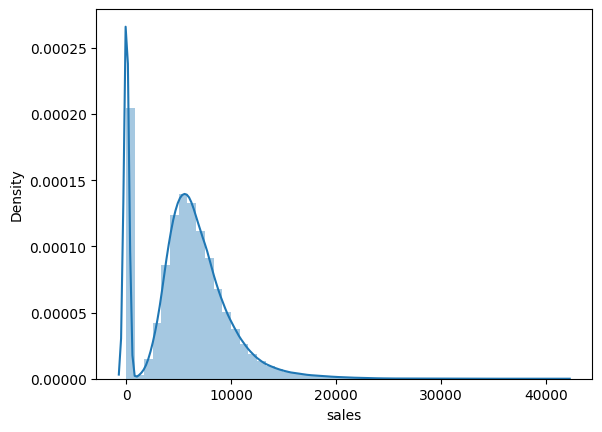

In [16]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

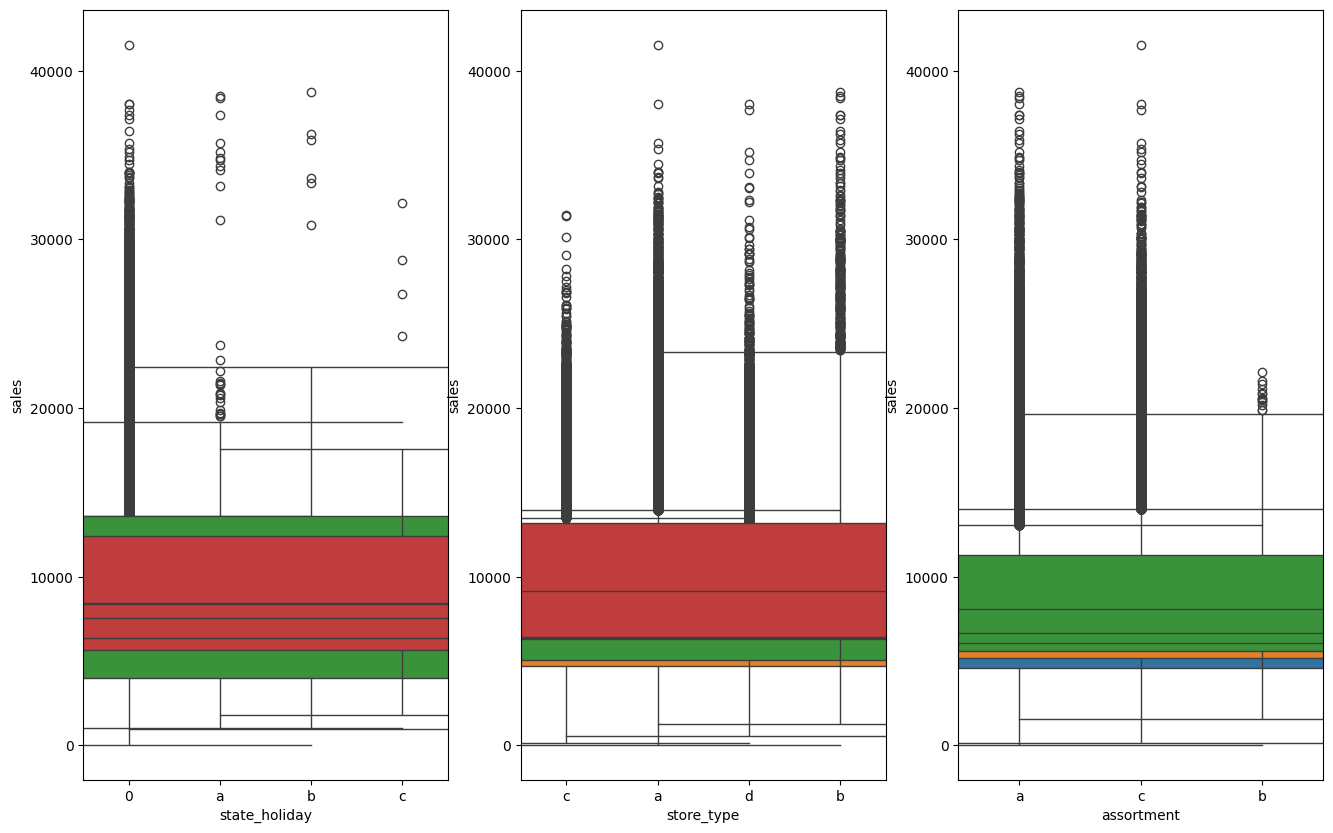

In [18]:
aux1 = df1[(df1['state_holiday'] !=0) & (df1['sales']>0)]

plt.figure(figsize=(16,10))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday', legend=False, width=8)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue='store_type', legend=False, width=8)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue='assortment', legend=False,width=8)
plt.show()

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## Mind Map Hypothesis

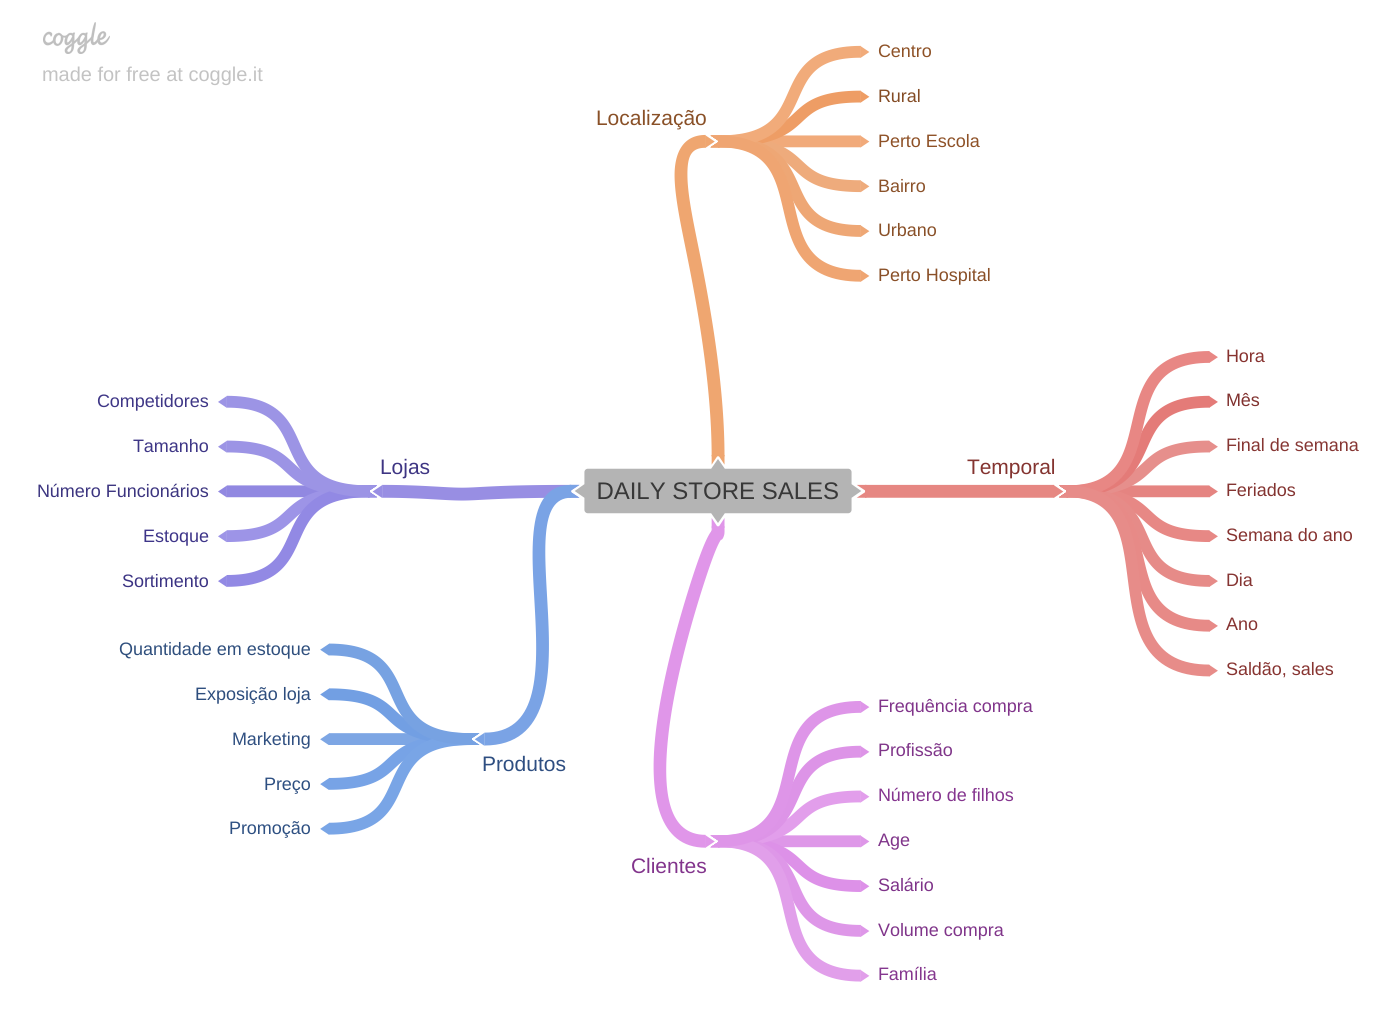

In [20]:
Image('../img/mindmaphypothesis.png')

## 2.2 Criação das Hipoteses

### 2.2.1 Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que têm preços menores nos produtos deveriam deveriam vender mais.

**4.** Lojas que têm preços menores nos produtos por mais tempo deveriam vender mais.

**5.** Lojas que têm promoções mais agressivas (descontos maiores) deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas com mais dias de promoçãos deveriam vender mais.

### 2.2.3 Tempo (Sazonalidade)

**1.** Lojas deveriam vender menos durante os feriados escolares.

**2.** Lojas deveriam vender menos aos finais de semana.

**3.** Lojas abertas durante o feriado de Natal deveriam deveriam vender mais.

**4.** Lojas deveriam vender mais ao longo dos anos.

**5.** Lojas deveriam vender mais no segundo semestre do ano.

**6.** Lojas deveriam vender mais depois do dia 10 de cada mês.

## 2.3 Lista final de hipóteses (Priorizar)

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas que têm preços menores nos produtos por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promoçãos deveriam vender mais.

**7.** Lojas deveriam vender menos durante os feriados escolares.

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas abertas durante o feriado de Natal deveriam deveriam vender mais.

**10.** Lojas deveriam vender mais ao longo dos anos.

**11.** Lojas deveriam vender mais no segundo semestre do ano.

**12.** Lojas deveriam vender mais depois do dia 10 de cada mês.

## 2.4 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype(int)
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [22]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                month=x['competition_open_since_month'],
                                                                day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


In [23]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1',
                                                                                   '%Y-%W-%w') - 
                                              datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [24]:
#assortment
df2['assortment'] = ['basic' if i == 'a' else 'extra' if i == 'b' else 'extended' for i in df2['assortment']]

#state_holiday
df2['state_holiday'] = ['public_holiday' if i == 'a' else 'easter_holiday' if i == 'b' else 'christmas' if i == 'c' else 'regular_day' for i in df2['state_holiday']]

In [25]:
df2.sample(4).T

61169                76686   \
store                                         960                  867   
day_of_week                                     7                    7   
date                          2015-06-07 00:00:00  2015-05-24 00:00:00   
sales                                           0                 1265   
customers                                       0                  146   
open                                            0                    1   
promo                                           0                    0   
state_holiday                         regular_day          regular_day   
school_holiday                                  0                    0   
store_type                                      d                    d   
assortment                                  basic             extended   
competition_distance                       8990.0              21810.0   
competition_open_since_month                    6                    9   
competition_open_since_year                  2015                 2012   
promo2                                          1                    0   
promo2_since_week                              31                   21   
promo2_since_year                            2009                 2015   
promo_interval                    Feb,May,Aug,Nov                    0   
month_map                                     Jun                  May   
is_promo                                        0                    0   
year                                         2015                 2015   
month                                           6                    5   
day                                             7                   24   
week_of_year                                   23                   21   
year_week                                 2015-22              2015-20   
competition_since             2015-06-01 00:00:00  2012-09-01 00:00:00   
competition_time_month                          0                   33   
promo_since                   2009-07-27 00:00:00  2015-05-18 00:00:00   
promo_time_week                               305                    0   

                                           820230               522111  
store                                         376                 1077  
day_of_week                                     3                    5  
date                          2013-06-26 00:00:00  2014-03-21 00:00:00  
sales                                        6422                 5197  
customers                                     838                  553  
open                                            1                    1  
promo                                           0                    1  
state_holiday                         regular_day          regular_day  
school_holiday                                  1                    0  
store_type                                      a                    a  
assortment                                  basic                basic  
competition_distance                        160.0               3750.0  
competition_open_since_month                    8                   11  
competition_open_since_year                  2012                 2001  
promo2                                          0                    1  
promo2_since_week                              26                   35  
promo2_since_year                            2013                 2010  
promo_interval                                  0     Mar,Jun,Sept,Dec  
month_map                                     Jun                  Mar  
is_promo                                        0                    1  
year                                         2013                 2014  
month                                           6                    3  
day                                            26                   21  
week_of_year                                   26                   12

In [26]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int32
month        

# 3.0 Filtragem de Variáveis

In [27]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [28]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.2 Seleção das colunas

In [29]:
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória dos Dados

In [30]:
df4 = df3.copy()

In [31]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

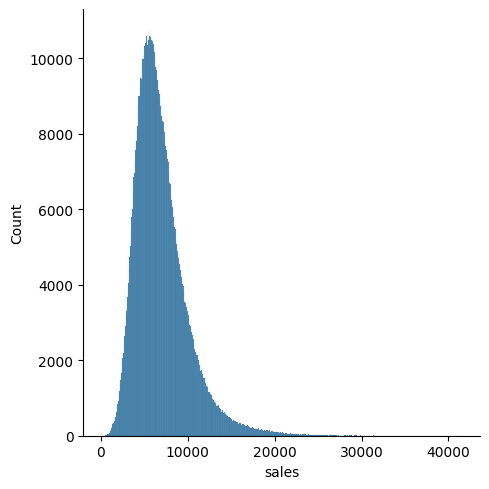

In [32]:
sns.displot(df4['sales'], kde=False)

### 4.1.2 Numerical Variable

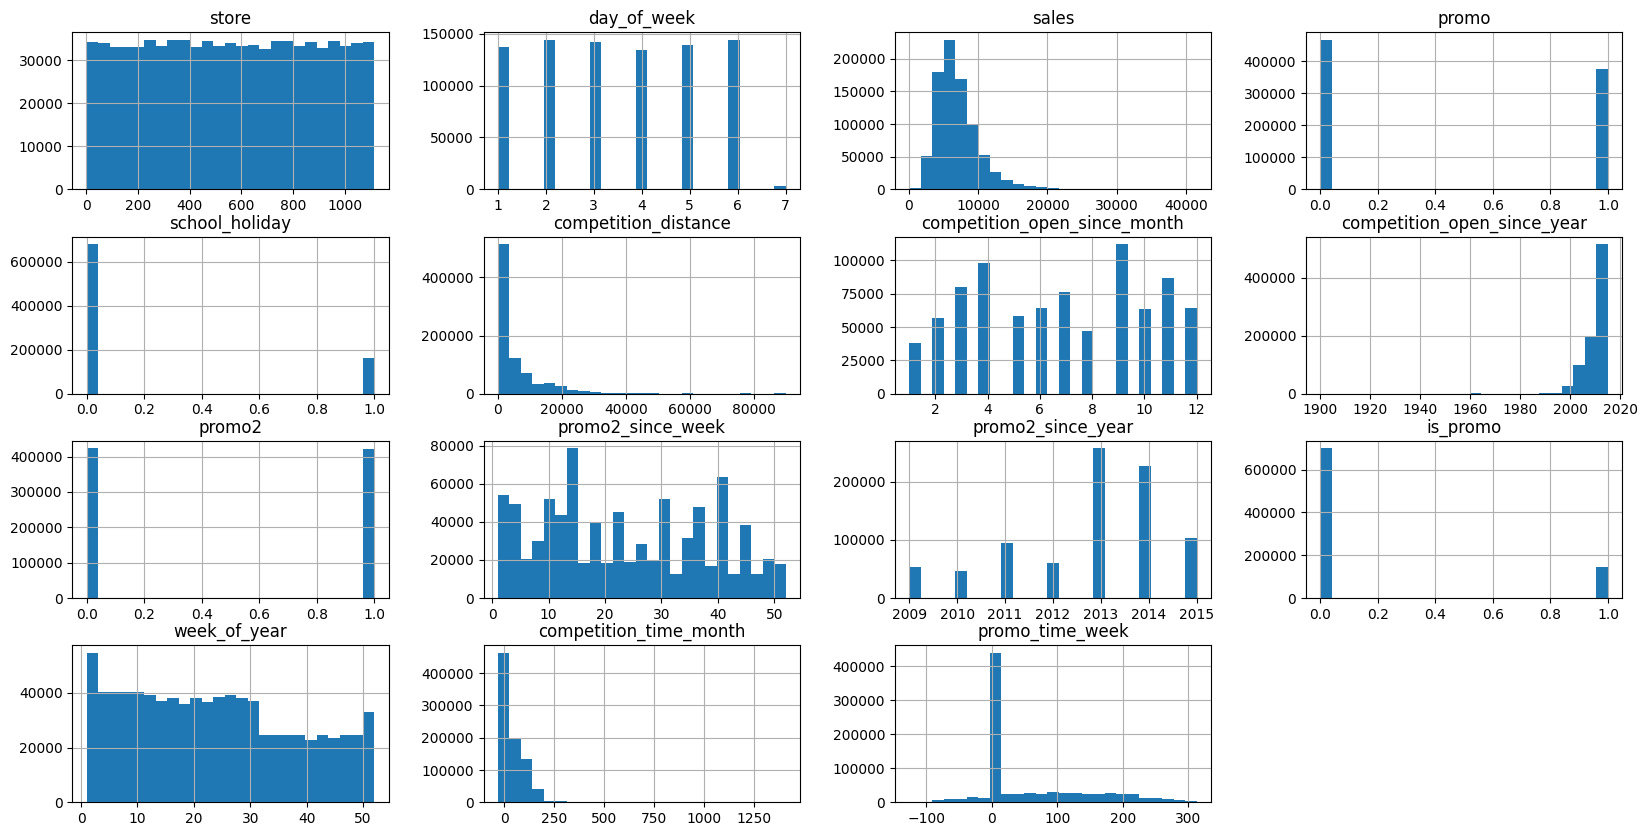

In [33]:
num_attributes.hist(bins = 25, figsize=(20,10));

### 4.1.3 Categorical Variable

In [34]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [35]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

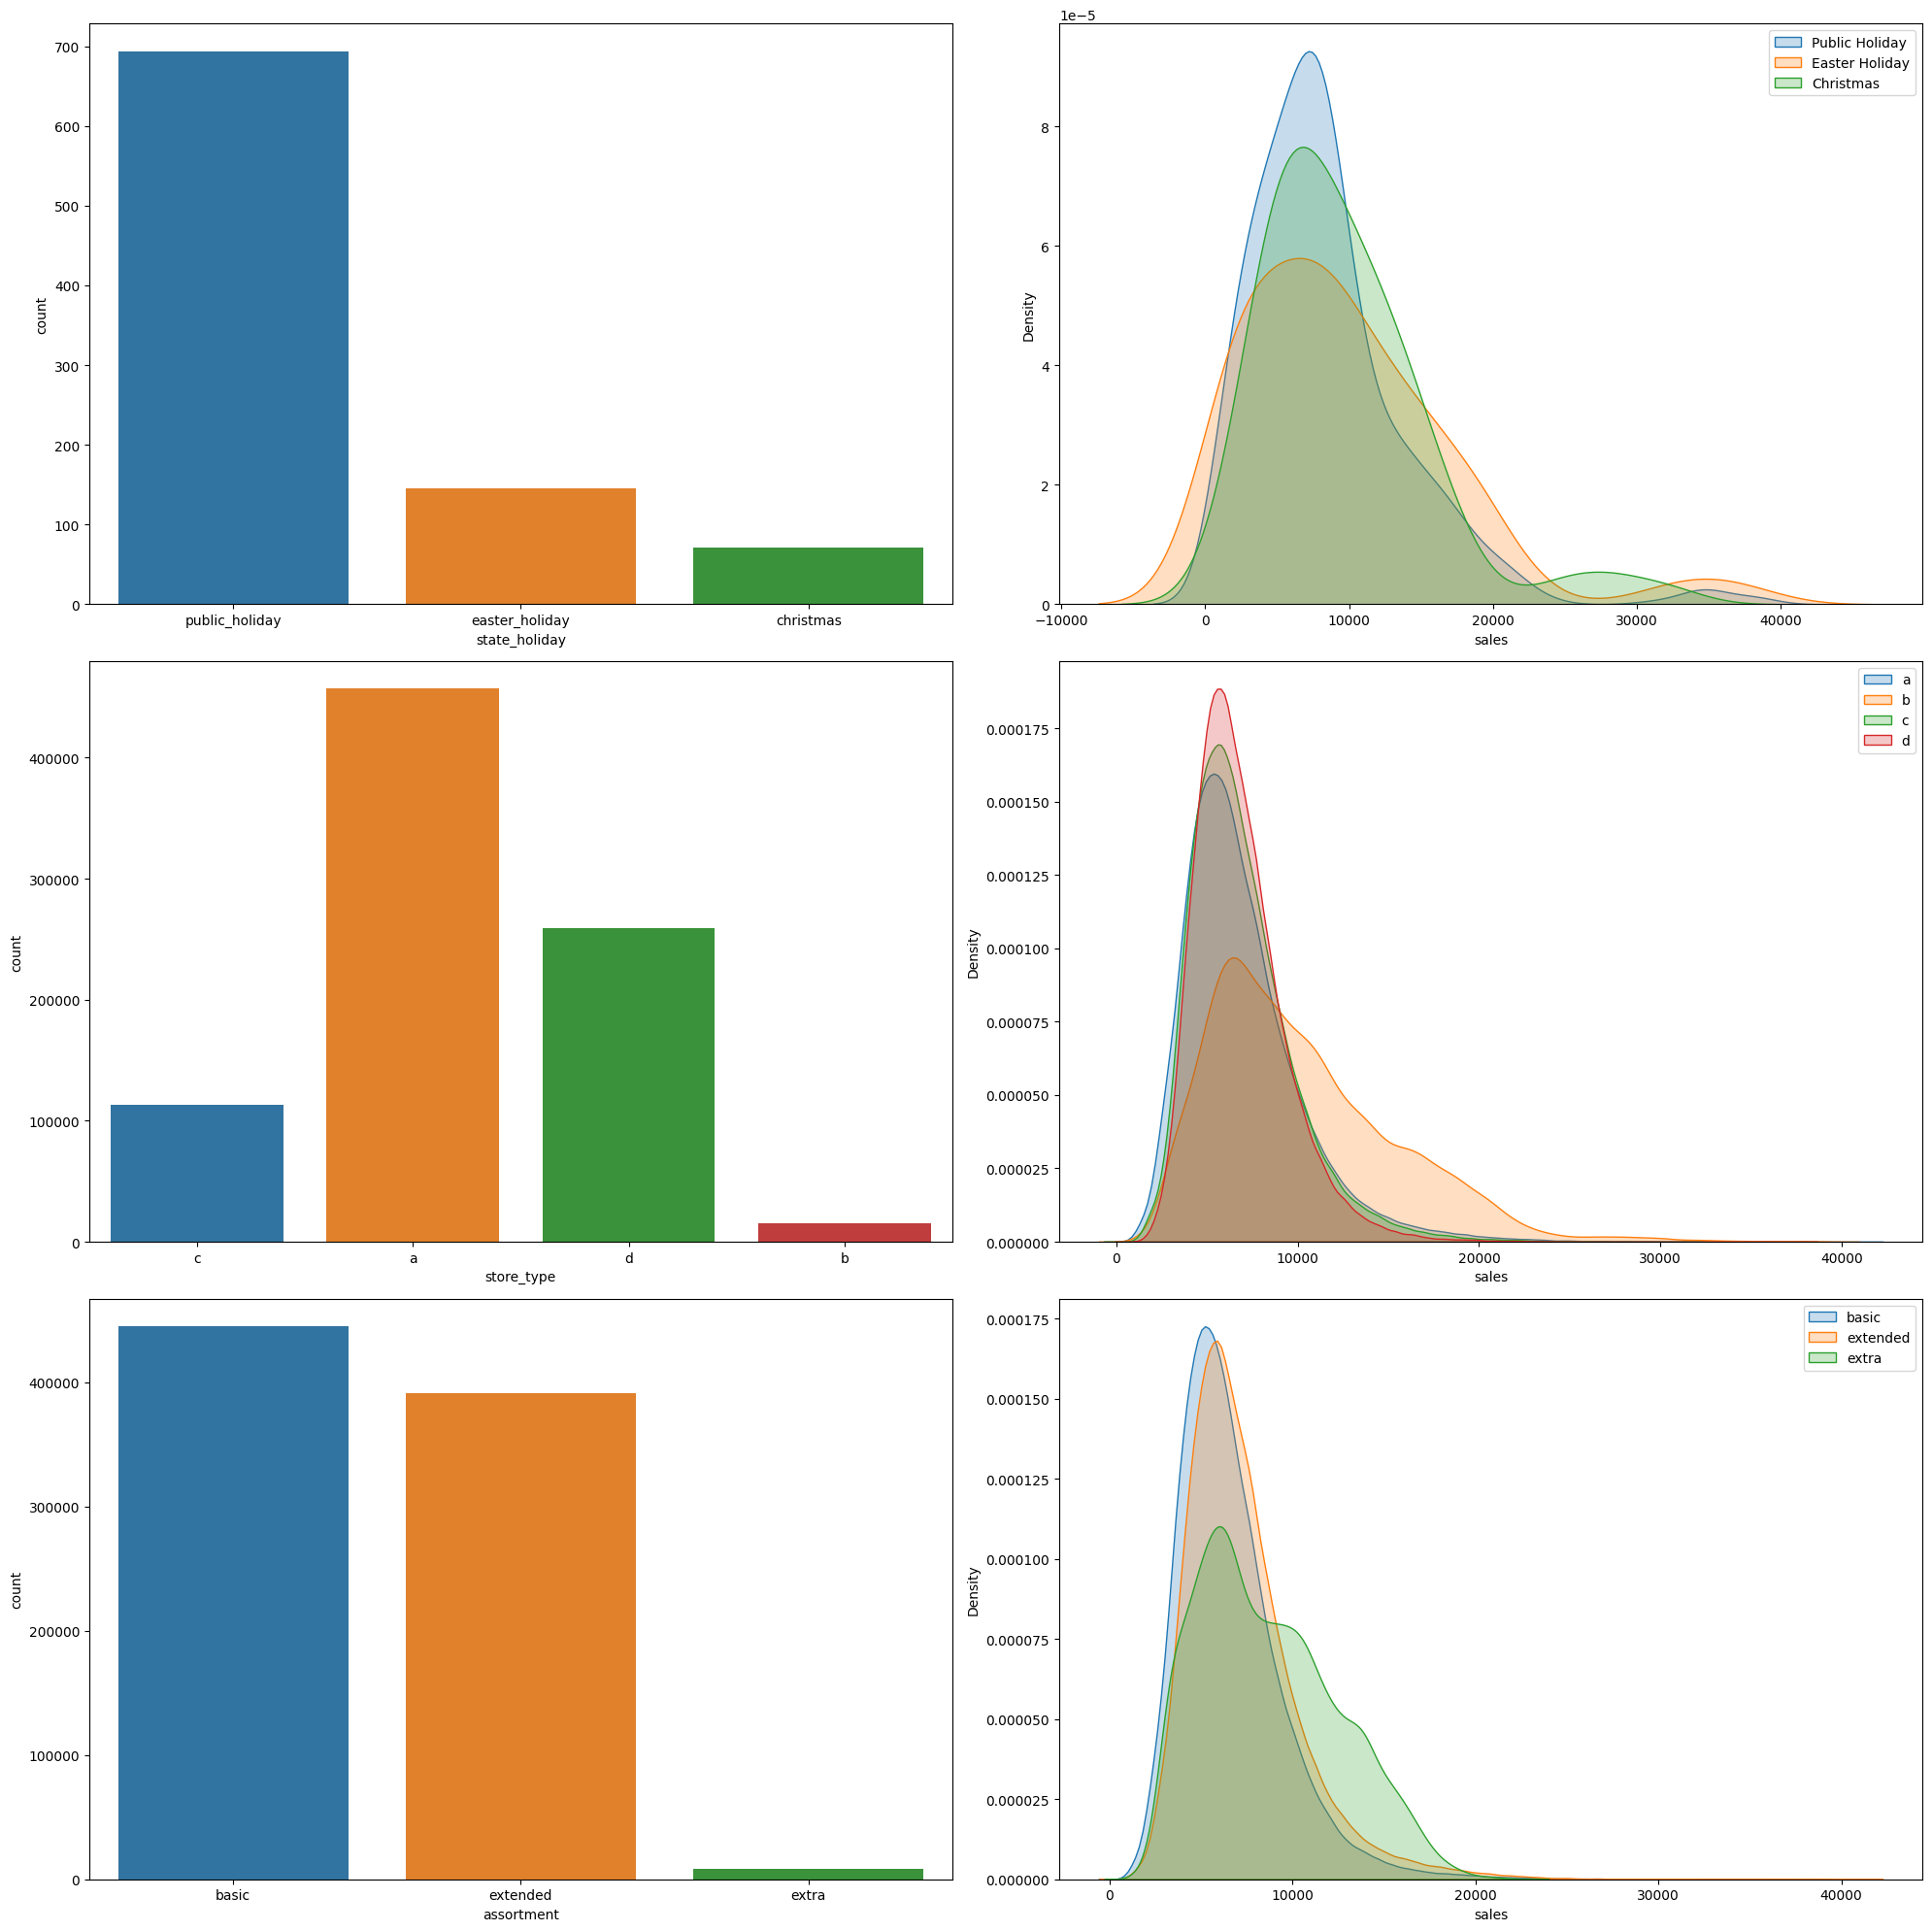

In [37]:
# state holiday
holiday = df4.loc[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
sns.countplot(x='state_holiday', hue='state_holiday', data=holiday, orient='v', legend=False)

plt.subplot(3,2,2)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'public_holiday']['sales'], fill = True, label='Public Holiday')
sns.kdeplot(df4.loc[df4['state_holiday'] == 'easter_holiday']['sales'], fill = True, label='Easter Holiday')
sns.kdeplot(df4.loc[df4['state_holiday'] == 'christmas']['sales'], fill = True, label='Christmas')
plt.legend(loc='upper right')
plt.tight_layout()

#store type
plt.subplot(3,2,3)
sns.countplot(x='store_type', hue='store_type', data=df4, orient='v', legend=False)

plt.subplot(3,2,4)
sns.kdeplot(df4.loc[df4['store_type'] == 'a']['sales'], fill = True, label='a')
sns.kdeplot(df4.loc[df4['store_type'] == 'b']['sales'], fill = True, label='b')
sns.kdeplot(df4.loc[df4['store_type'] == 'c']['sales'], fill = True, label='c')
sns.kdeplot(df4.loc[df4['store_type'] == 'd']['sales'], fill = True, label='d')
plt.legend(loc='upper right')
plt.tight_layout()

#assortments
plt.subplot(3,2,5)
sns.countplot(x='assortment', hue='assortment', data=df4, orient='v', legend=False)

plt.subplot(3,2,6)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic']['sales'], fill = True, label='basic')
sns.kdeplot(df4.loc[df4['assortment'] == 'extended']['sales'], fill = True, label='extended')
sns.kdeplot(df4.loc[df4['assortment'] == 'extra']['sales'], fill = True, label='extra')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

## 4.2 Análise Bivariada

### **Hipótese 1:** Lojas com maior sortimento deveriam vender mais
**Falsa:** Lojas com MAIOR sortimento vendem MENOS.

<Axes: xlabel='year_week'>

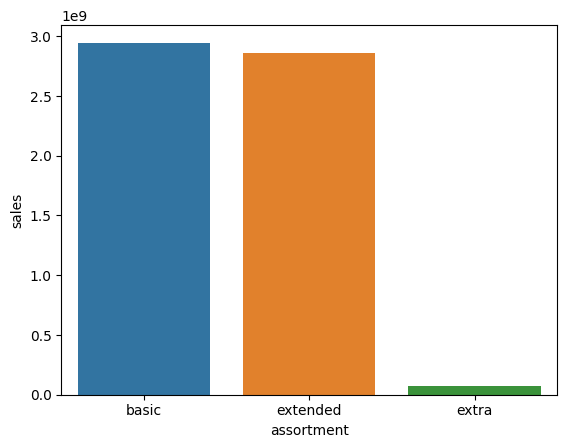

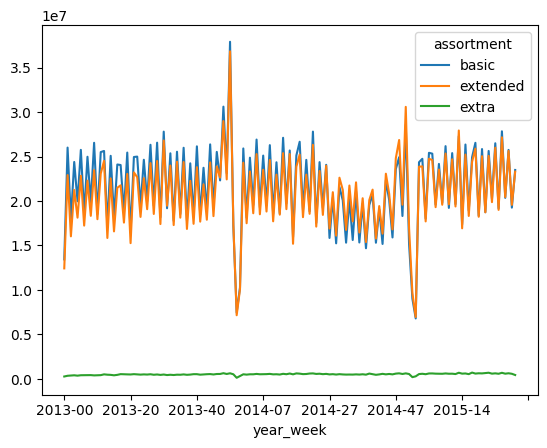

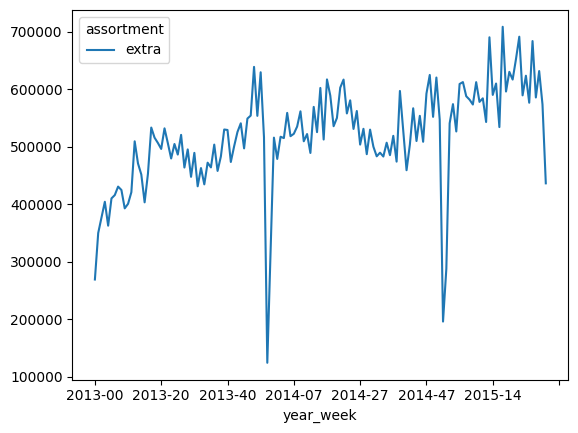

In [38]:
cols = ['sales', 'assortment']
aux = df4.loc[:, cols].groupby(['assortment']).sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux, hue='assortment')

aux2 = df4.loc[:, ['sales', 'year_week','assortment']].groupby(['year_week','assortment']).sum().reset_index()
aux2 =aux2.pivot(index='year_week', columns='assortment', values='sales')
aux2.plot()

only_extra = df4['assortment'] == 'extra'
aux3 = df4.loc[only_extra, ['sales', 'year_week','assortment']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux3.pivot(index='year_week', columns='assortment', values='sales')
aux3.plot()

#### gráficos com plotly

In [39]:
px.bar(aux, x='assortment', y='sales', color='assortment')

In [40]:
#não pode usar o pivot
aux2b = df4.loc[:, ['sales', 'year_week','assortment']].groupby(['year_week','assortment']).sum().reset_index()
px.line(aux2b, x='year_week', y='sales', color='assortment')

In [41]:
aux3b = df4.loc[only_extra, ['sales', 'year_week','assortment']].groupby(['year_week','assortment']).sum().reset_index()
px.line(aux3b, x='year_week', y='sales', color='assortment')

### **Hipótese 2:** Lojas com competidores mais próximos deveriam vender menos.
**FALSA:** Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

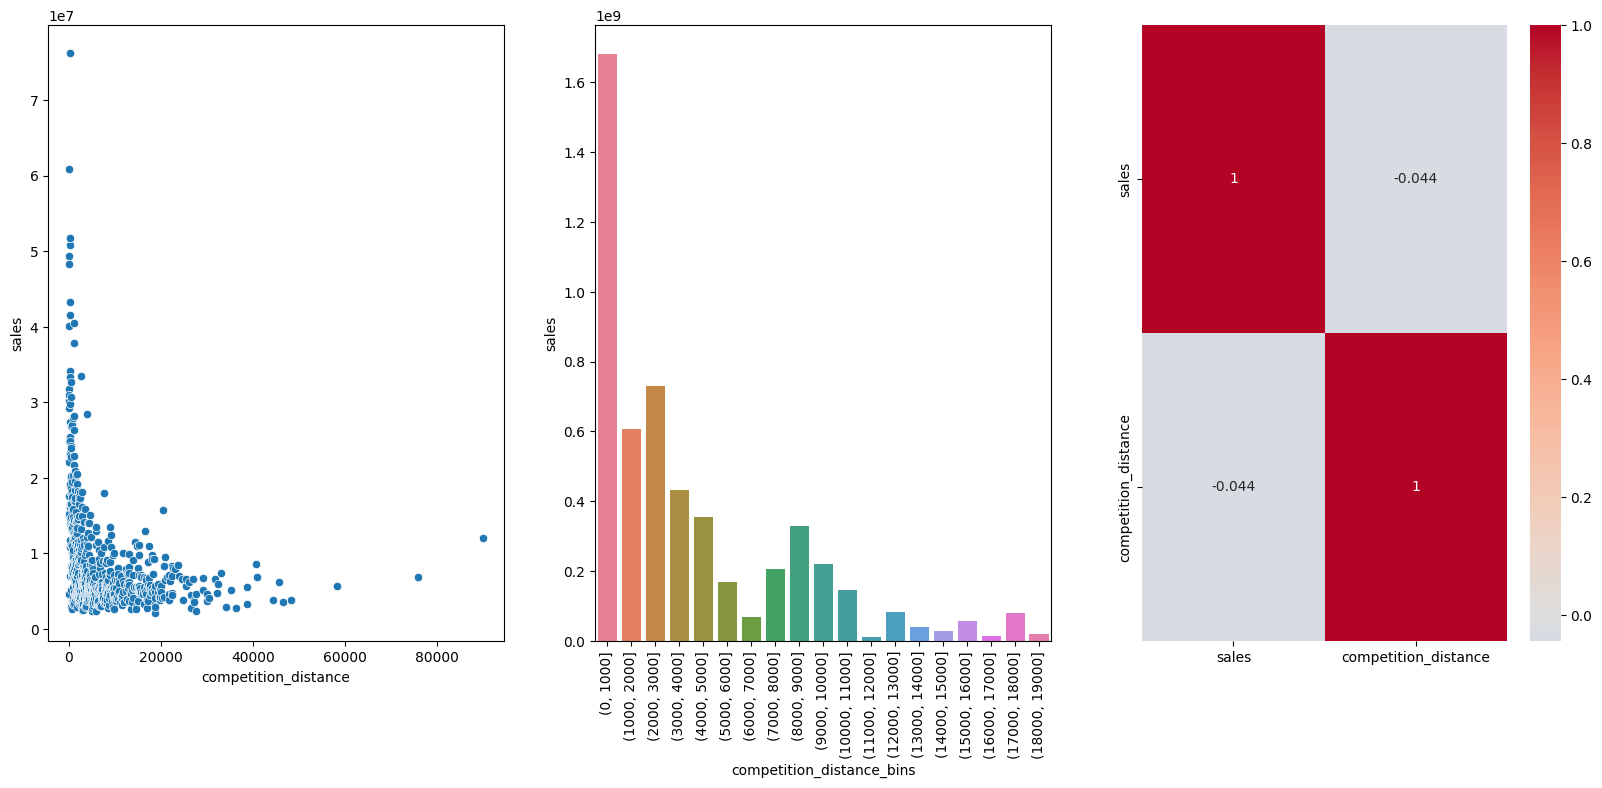

In [42]:
aux = df4.loc[:, ['sales', 'competition_distance']].groupby(['competition_distance']).sum()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux['competition_distance_bins'] = pd.cut(df4['competition_distance'], bins)
aux2 = aux.loc[:, ['sales', 'competition_distance_bins']].groupby(['competition_distance_bins']).sum().reset_index()
sns.barplot(x='competition_distance_bins', y='sales', data=aux2, hue='competition_distance_bins',legend=False);
plt.xticks(rotation=90)


plt.subplot(1,3,3)
auxh = df4.loc[:, ['sales', 'competition_distance']]
sns.heatmap(auxh.corr(method='pearson'), annot=True,cmap='coolwarm', center=0)
plt.show()

#### fazer graficos plotly

### **Hipótese 3:** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA:** Lojas com competidores abertos a MAIS TEMPO vendem MAIS.

In [43]:
filtro = (df4['competition_time_month']<120) & (df4['competition_time_month'] !=0)
cols = ['sales', 'competition_time_month']
aux1 = df4.loc[filtro, cols].groupby(['competition_time_month']).sum().reset_index()
px.bar(aux1, x='competition_time_month', y='sales', color='competition_time_month')

<Axes: xlabel='competition_time_month', ylabel='sales'>

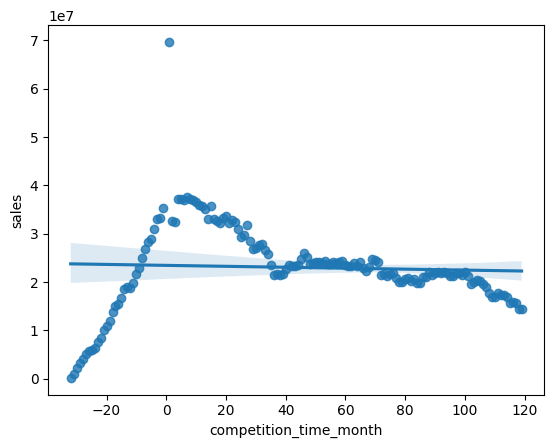

In [44]:
sns.regplot(data=aux1, x='competition_time_month', y='sales')

<Axes: >

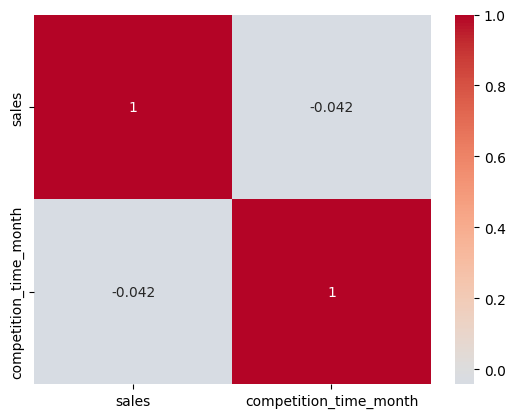

In [45]:
auxh = df4.loc[filtro, cols]
sns.heatmap(auxh.corr(method='pearson'), annot=True,cmap='coolwarm', center=0)

### **Hipótese 4:** Lojas com promoções ativas há mais tempo deveriam vender mais
**False:** Lojas com promoções ativas vendem menos depois de um certo período de promoção.

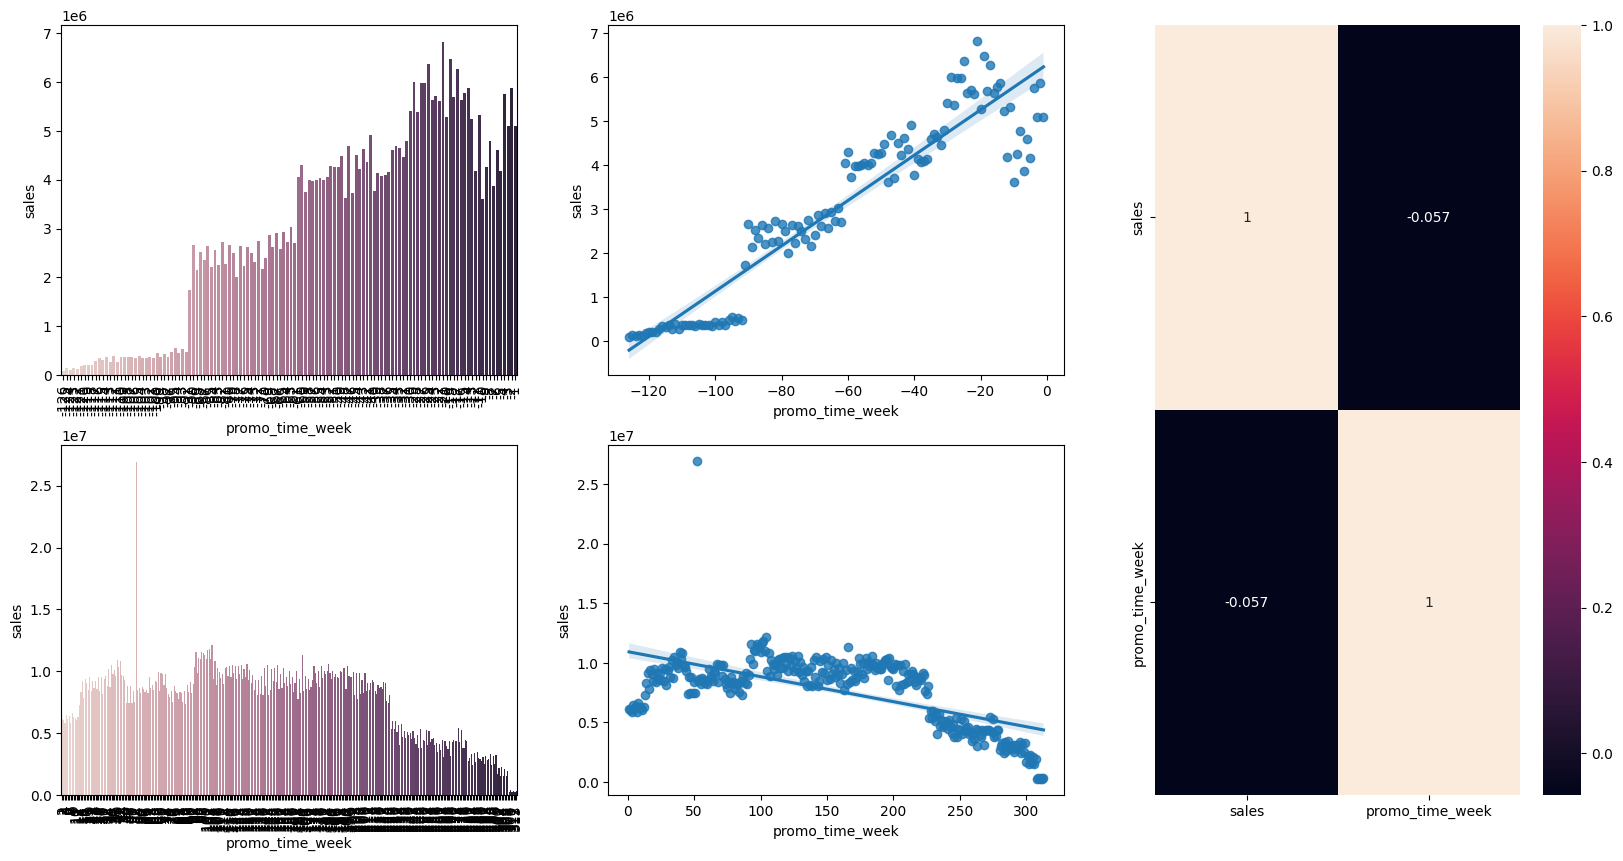

In [46]:
cols = ['sales', 'promo_time_week']
only_promo1 = df4['promo_time_week']<0
promo2 = df4['promo_time_week']>0
aux_promo1 = df4.loc[only_promo1, cols].groupby(['promo_time_week']).sum().reset_index()
aux_promo2 = df4.loc[promo2, cols].groupby(['promo_time_week']).sum().reset_index()

plt.figure(figsize=(20,10))
grid=grids.GridSpec(2,3)
plt.subplot(grid[0,0])
sns.barplot(data=aux_promo1, x='promo_time_week', y='sales', hue='promo_time_week', legend=False)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(data=aux_promo1, x='promo_time_week', y='sales')

plt.subplot(grid[1,0])
sns.barplot(data=aux_promo2, x='promo_time_week', y='sales', hue='promo_time_week', legend=False)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(data=aux_promo2, x='promo_time_week', y='sales')

plt.subplot(grid[:,2])
sns.heatmap(data = df4.loc[:, cols].corr(method='pearson'), annot=True)
plt.show()

#### gráficos plotly

In [47]:
fig1 = px.bar(aux_promo1, x='promo_time_week', y ='sales', title='Traditional Promo')
fig2 = px.bar(aux_promo2, x='promo_time_week', y ='sales', title='Traditional Promo & Extended')
fig1.show()
fig2.show()

### **Hipótese 5:** Lojas com mais dias de promoções deveriam vender mais
**Recusada:** hipótese não será trabalhada no primeiro ciclo de avaliação devido à semelhança com hipótese anterior.

### **Hipótese 6:** Lojas com mais promoções consecutivas deveriam vender mais
**Falsa:** Lojas com mais promoções consecutivas vendem menos.

In [48]:
cols = ['sales', 'promo', 'promo2']
aux = df4.loc[:, cols].groupby(['promo', 'promo2']).sum().reset_index()
aux.sort_values('promo')

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

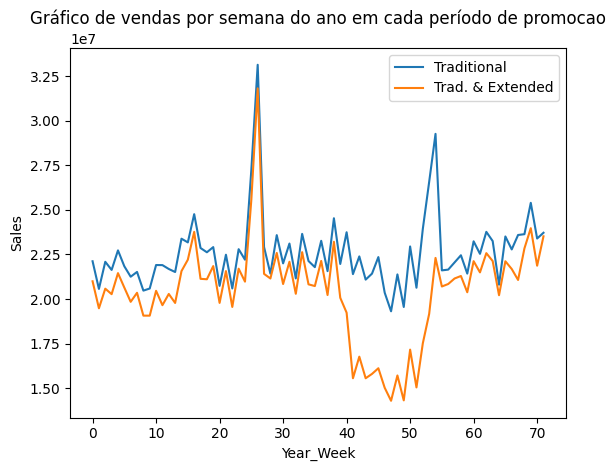

In [49]:
promo_trad = (df4['promo'] ==1) & (df4['promo2'] ==0)
promo_extd = (df4['promo'] ==1) & (df4['promo2'] ==1)
cols = ['sales', 'year_week']

aux_trad = df4.loc[promo_trad, cols].groupby(['year_week']).sum().reset_index()
ax=aux_trad.plot()

aux_extd = df4.loc[promo_extd, cols].groupby(['year_week']).sum().reset_index()
aux_extd.plot(ax=ax)

ax.set_title('Gráfico de vendas por semana do ano em cada período de promocao')
ax.set_xlabel('Year_Week')
ax.set_ylabel('Sales')
ax.legend(labels = ['Traditional', 'Trad. & Extended'])

### **Hipótese 7:** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA:** Lojas vendem menos durante feriados escolares, exceto mês de Agosto (Julho muito próximo). 

In [50]:
cols = ['sales', 'school_holiday']
aux = df4.loc[:, cols].groupby('school_holiday').sum().reset_index()
aux['school_holiday'] = aux['school_holiday'].astype(str)
px.bar(aux, x='school_holiday', y='sales', color='school_holiday', title="Vendas durante feriados escolares")

In [51]:
cols2 = ['sales', 'month', 'school_holiday']
aux2 = df4.loc[:, cols2].groupby(['month', 'school_holiday']).sum().reset_index()
aux2['school_holiday'] = aux2['school_holiday'].astype(str)
aux2['month'] = aux2['month'].astype(str)
px.bar(aux2, x='month', y='sales',color='school_holiday' , title="Vendas por mês em relação a feriados escolares")

### **Hipótese 8:** Lojas deveriam vender menos aos finais de semana.
**Falsa:** Lojas vendem menos durantes finais de semana.

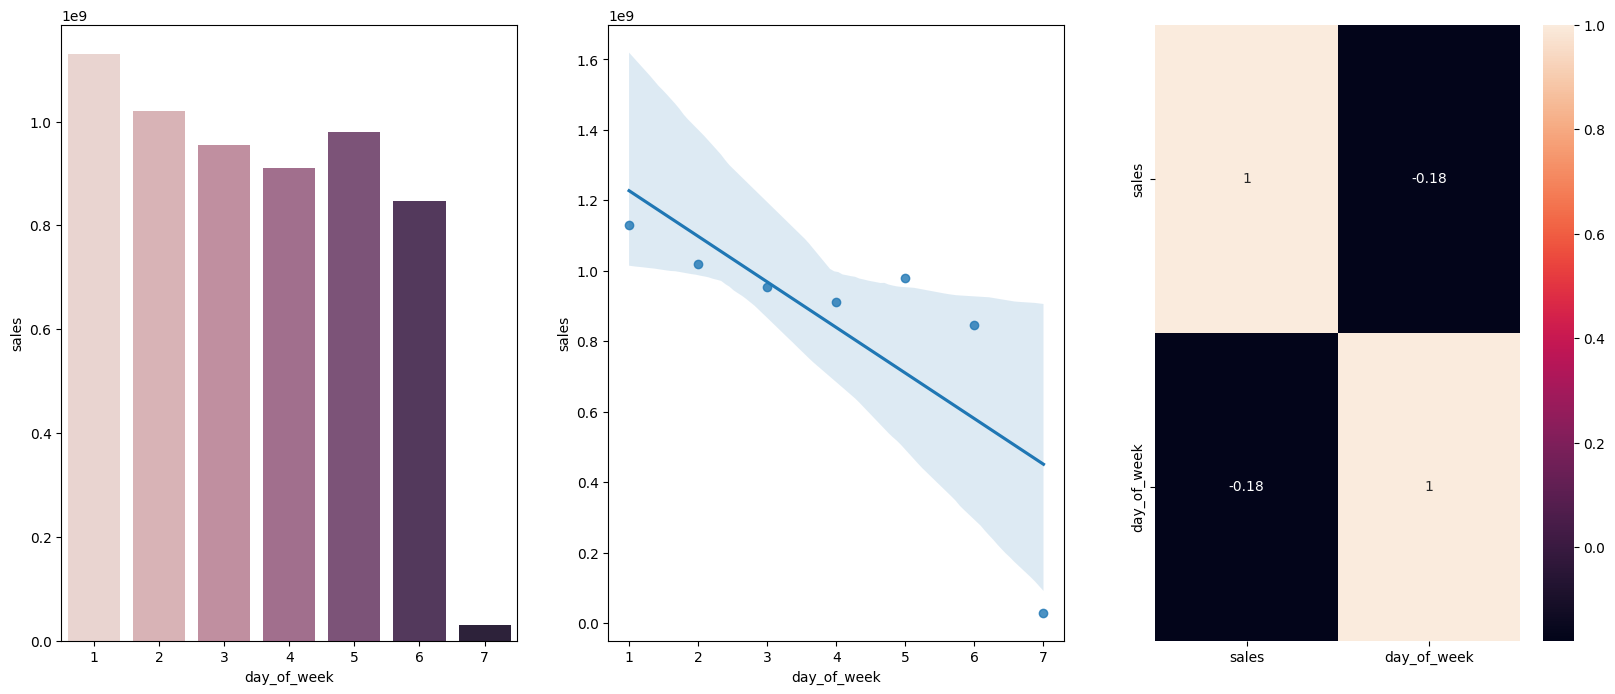

In [52]:
cols = ['sales', 'day_of_week']
aux = df4.loc[:, cols].groupby(['day_of_week']).sum().sort_values('day_of_week').reset_index()
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', hue='day_of_week', data=aux, legend=False)
plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4.loc[:, cols].corr(method='pearson'), annot=True)
plt.show()

In [53]:
aux['day_of_week'] = aux['day_of_week'].astype(str)
px.bar(aux, x='day_of_week', y='sales', color='day_of_week', title='Vendas por dia da semana')

### **Hipótese 9:** Lojas abertas durante o feriado de Natal deveriam deveriam vender mais
**Falsa:** Lojas abertas durante o feriado de Natal não vendem mais

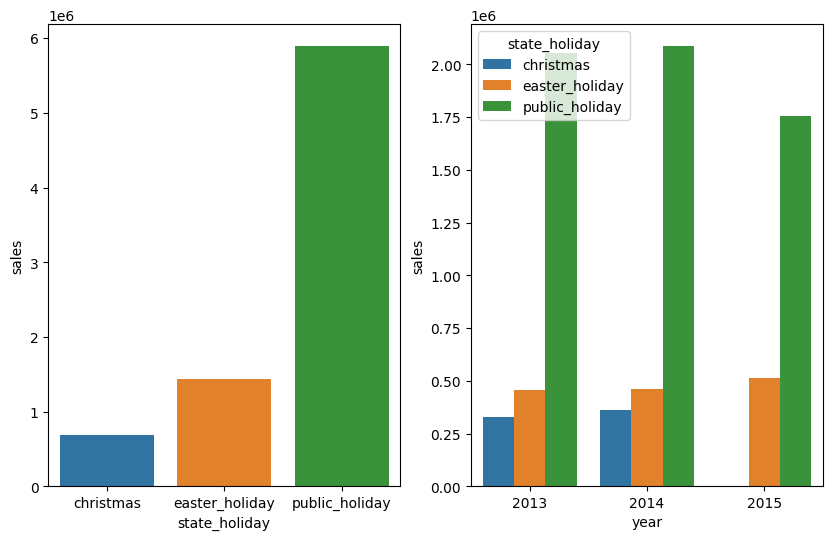

In [54]:
holidays = (df4['state_holiday'] != 'regular_day')
cols = ['sales', 'state_holiday']
aux = df4.loc[holidays, cols].groupby(['state_holiday']).sum().reset_index()
aux2 = df4.loc[holidays, ['sales', 'year', 'state_holiday']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux)
plt.subplot(1,2,2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.show()

### **Hipótese 10:** Lojas deveriam vender mais ao longo dos anos
**Falsa:** Lojas vendem menos ao longo dos anos.

<Axes: >

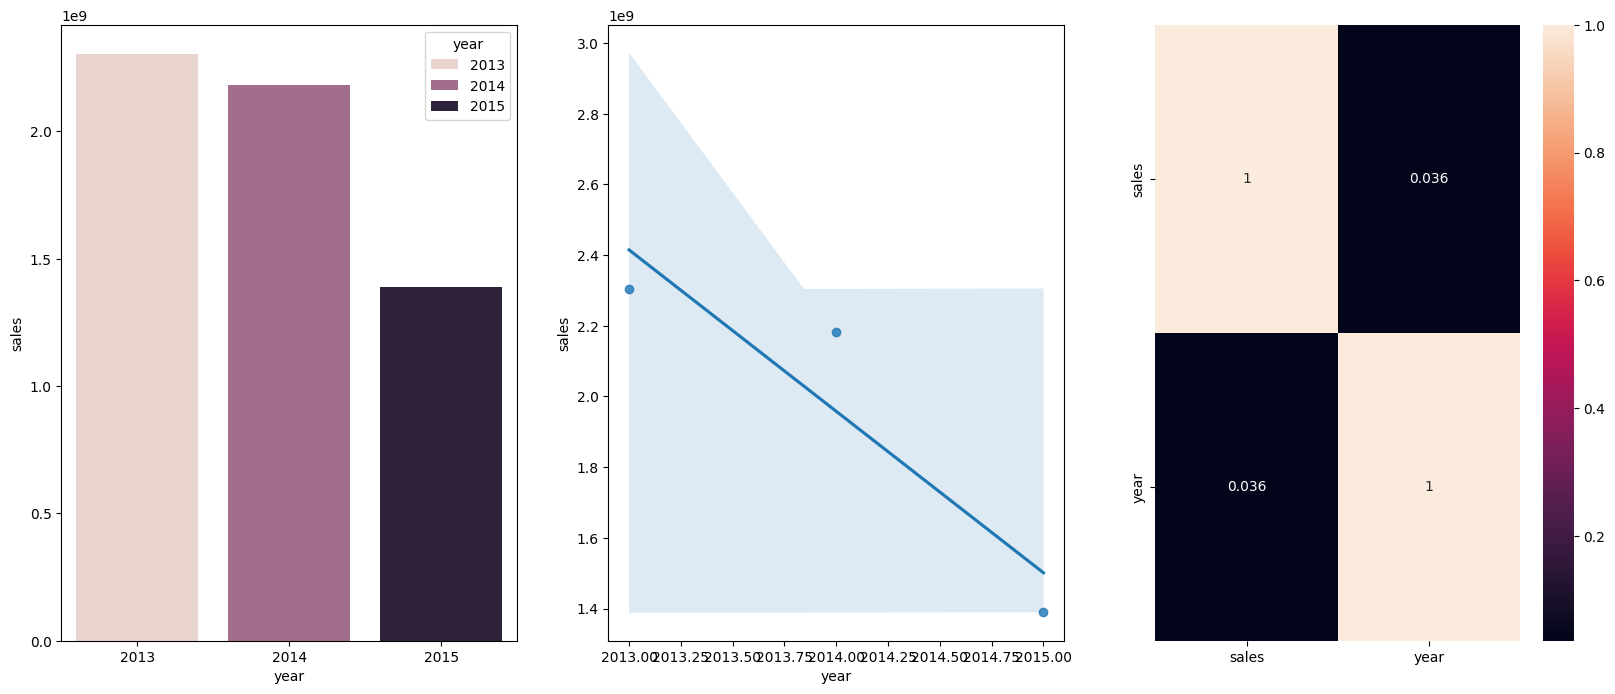

In [55]:
cols = ['sales', 'year']
aux = df4.loc[:, cols].groupby('year').sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', hue='year', data=aux)
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4.loc[:, cols].corr(method='pearson'), annot=True)

### **Hipótese 11:** Lojas deveriam vender mais no segundo semestre do ano.
**Falsa:** Lojas vendem menos no segundo semestre.

<Axes: >

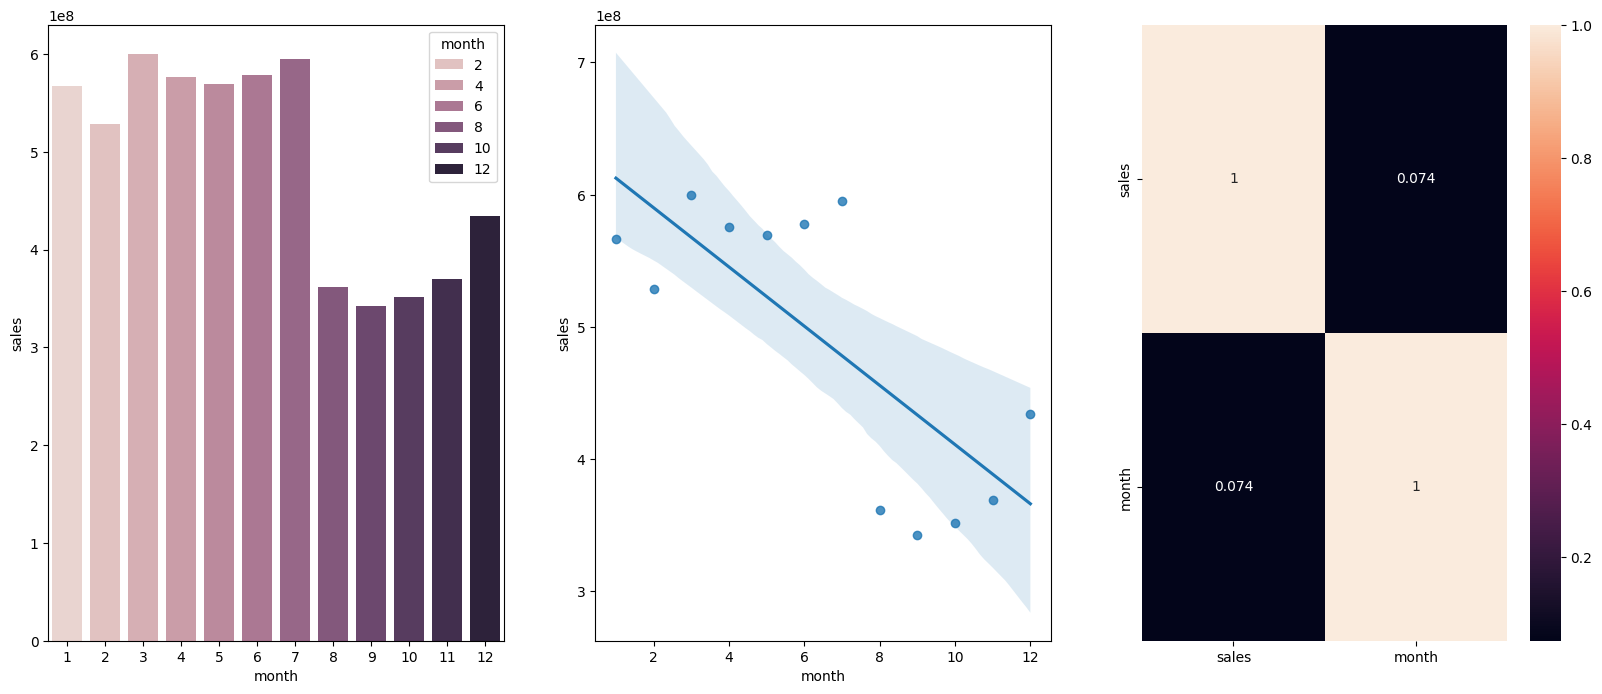

In [56]:
cols = ['sales', 'month']
aux = df4.loc[:, cols].groupby('month').sum().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', hue='month', data=aux)
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4.loc[:, cols].corr(method='pearson'), annot=True)

### **Hipótese 12:** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira:** Lojas vendem mais depois do dia 10 de cada mês.

<Axes: >

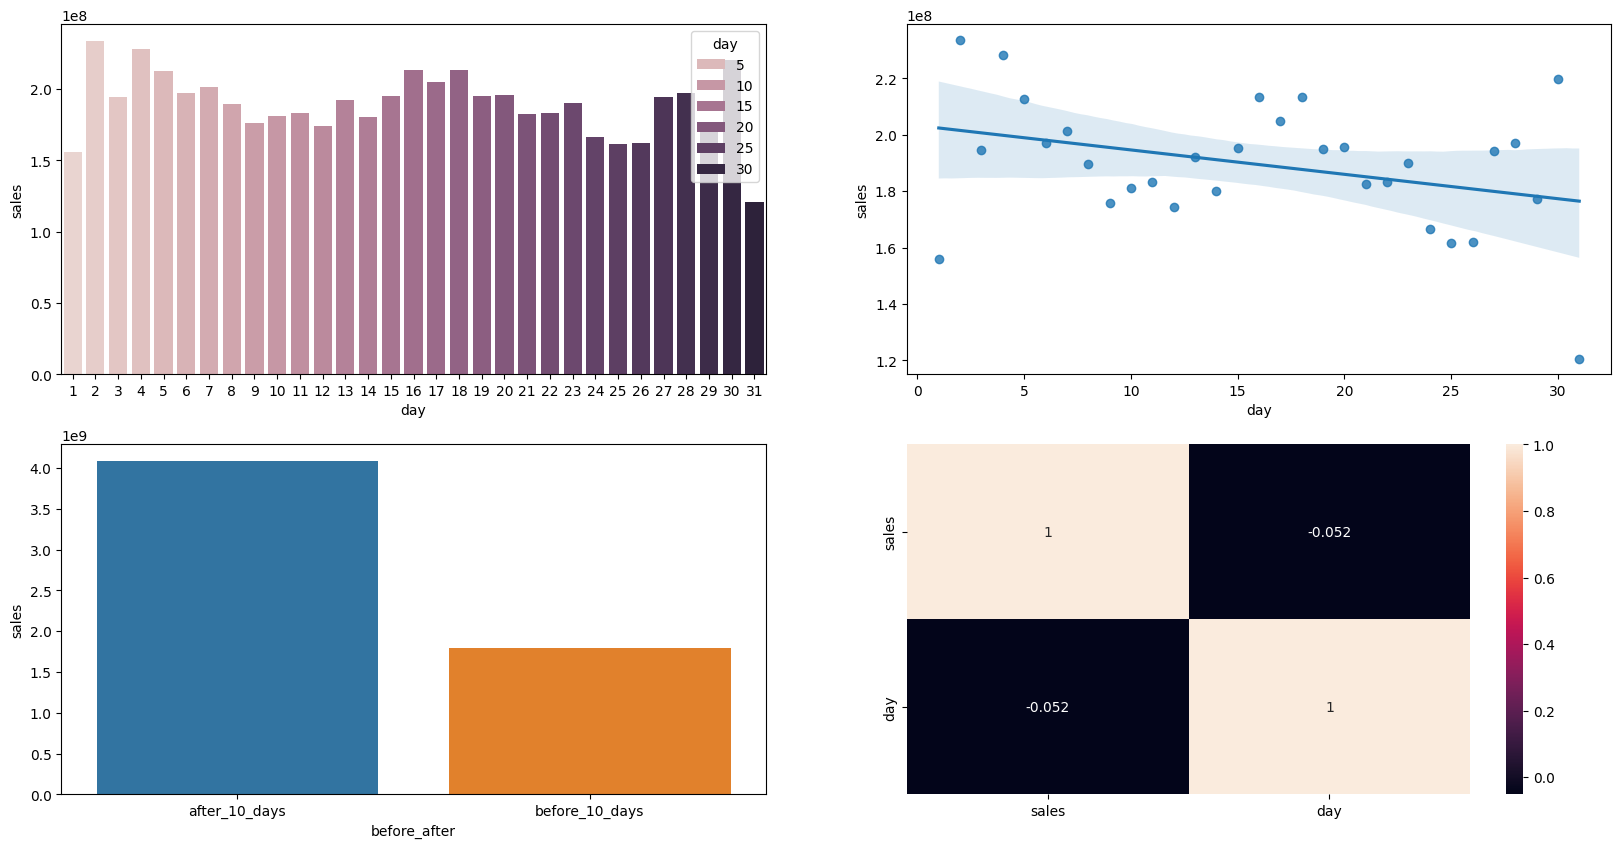

In [57]:
cols = ['sales', 'day']
aux = df4.loc[:, cols].groupby(['day']).sum().reset_index()
aux['before_after'] = ['after_10_days' if i >= 10 else 'before_10_days' for i in aux['day']]
aux2 = aux.loc[:, ['sales', 'before_after']].groupby('before_after').sum().reset_index()
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', hue='day', data=aux)
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux)
plt.subplot(2,2,3)
sns.barplot(x='before_after', y='sales', hue='before_after', data=aux2)
plt.subplot(2,2,4)
sns.heatmap(df4.loc[:, cols].corr(method='pearson'), annot=True)

In [58]:
px.bar(aux, x='before_after', y='sales', color='before_after')

### Resumo Hipóteses

In [59]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '---', '---'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta']]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           ---          ---
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

[]

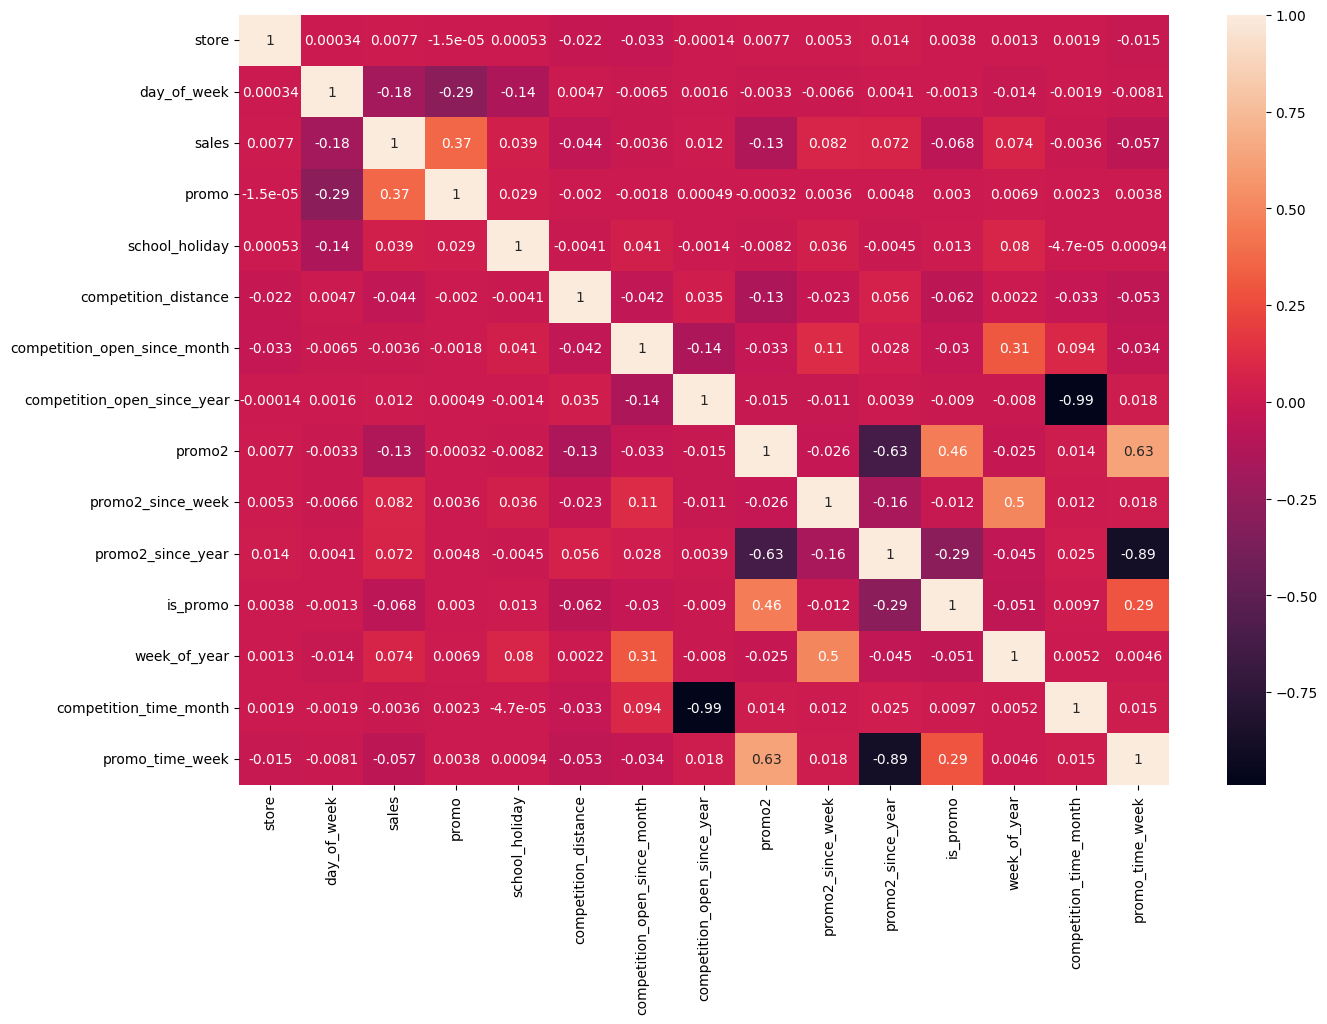

In [60]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True)
plt.plot()

### 4.3.2 Categorical Attributes

In [61]:
cat_attributes = df4.select_dtypes(include=['object'])
a = cat_attributes

In [62]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-((k-1)*(r-1))/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    v = np.sqrt(chi2corr/n) / (min(kcorr-1, rcorr-1))
    return v

In [63]:
a1 = cramer_v(a['store_type'], a['store_type'])
a2 = cramer_v(a['store_type'], a['state_holiday'])
a3 = cramer_v(a['store_type'], a['assortment'])
a4 = cramer_v(a['state_holiday'], a['store_type'])
a5 = cramer_v(a['state_holiday'], a['state_holiday'])
a6 = cramer_v(a['state_holiday'], a['assortment'])
a7 = cramer_v(a['assortment'], a['store_type'])
a8 = cramer_v(a['assortment'], a['state_holiday'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
d
                

state_holiday  store_type  assortment
state_holiday       0.577352    0.041029    0.380747
store_type          0.041029    0.577352    0.047762
assortment          0.380747    0.047762    0.707108

<Axes: >

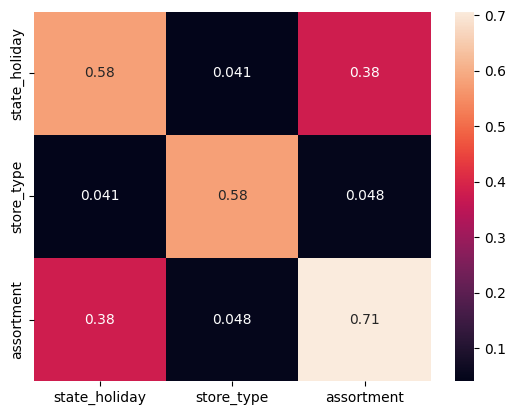

In [64]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

## 5.1 Normalização
não aplicada pois não há variáveis com ditribuição normal

## 5.2 Rescaling
aplicada em variáveis numéricas não-ciclicas.

In [66]:
#escolher variáveis para aplicar o rescaling
a = df5.select_dtypes(include=['int32', 'int64', 'float64'])
a.columns 

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'month', 'day', 'week_of_year',
       'competition_time_month', 'promo_time_week'],
      dtype='object')

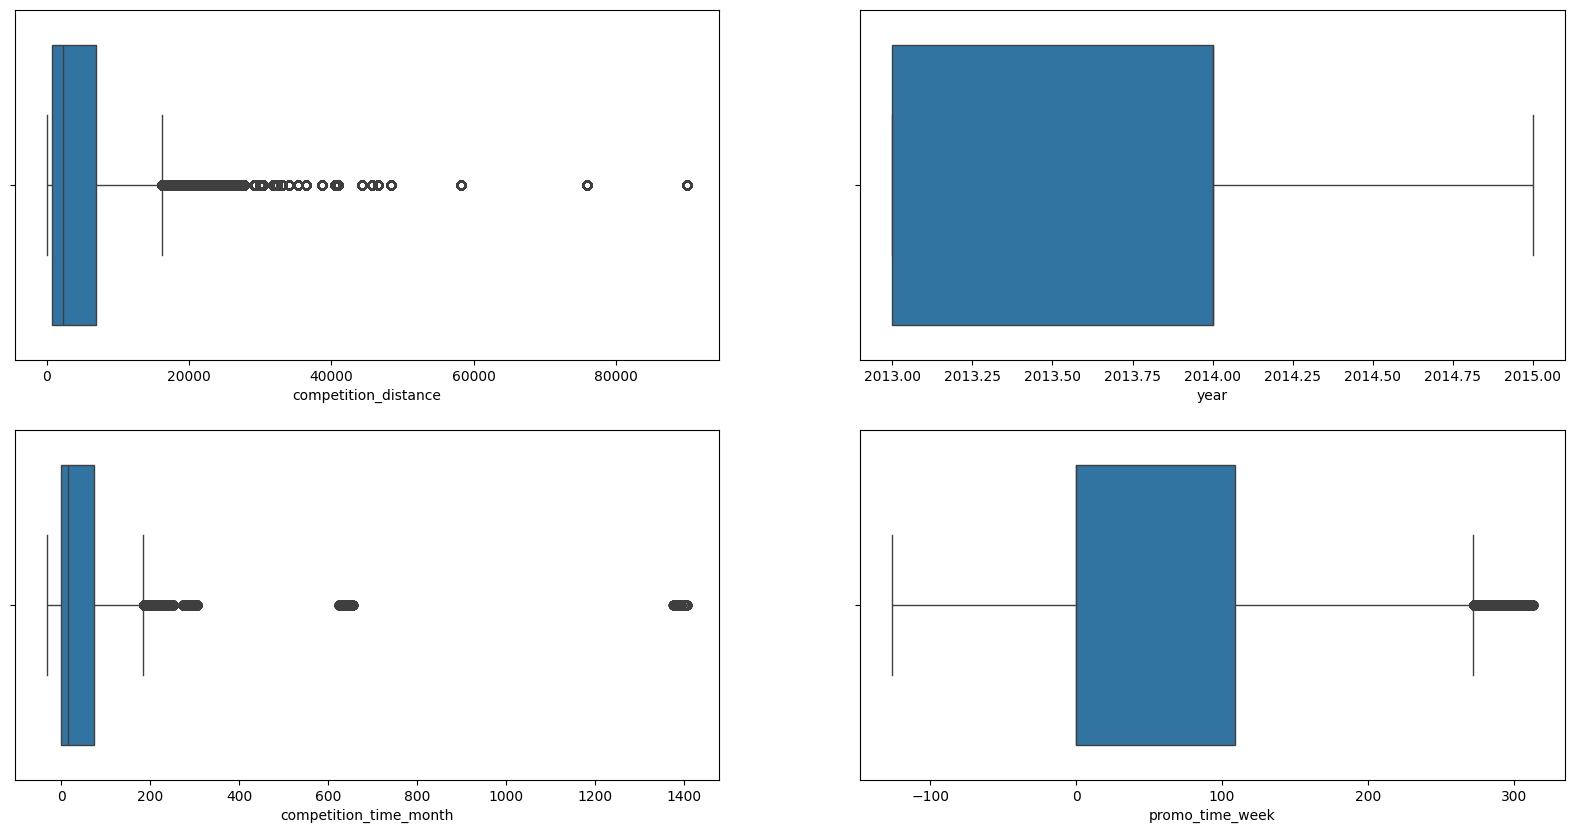

In [67]:
#verificando outliers
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'], orient = 'h')
plt.subplot(2,2,2)
sns.boxplot(df5['year'], orient = 'h')
plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month'], orient = 'h')
plt.subplot(2,2,4)
sns.boxplot(df5['promo_time_week'], orient = 'h')
plt.show()

In [68]:
#aplicar as reescalas
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../pickle/comp_distance_scaler.pkl', 'wb'))

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('../pickle/comp_timemonth_scaler.pkl', 'wb'))

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('../pickle/promo_timeweek_scaler.pkl', 'wb'))

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../pickle/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding
transformar variáveis categóricas em numéricas

In [69]:
#state_holiday - One Hot Encoding, bom para estado de coisas
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype='int64')

#store_type - Label Encoding, bom para variáveis categóricas sem ordem ou relevância
le = pp.LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../pickle/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding, bom para variáveis com intraordem.
assort_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assort_dict)

### 5.3.2 Response Variable Transformation
aplicada em variável resposta para ajustar distribuição normal.

In [70]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Transformation Natureza
aplicada em variável numérica ciclica.

In [71]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# 6.0 Feature Selection

In [72]:
df6 = df5.copy()

In [73]:
# separar variáveis originais que foram derivadas
cols_drop = ['day', 'month', 'week_of_year', 'day_of_week', 'year_week', 'promo_since', 'competition_since']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Split dataset into training dataset anda test dataset

In [74]:
#achar a última data da venda
last_date = df6.loc[:, ['date','store']].groupby(['store']).max().reset_index()['date'][0]

# separar data corte das ultimas 6 semanas para teste e treino
cut_date = last_date-datetime.timedelta(days=6*7)
train_filter = df6['date'] < cut_date
test_filter = df6['date'] >= cut_date

# separar dataset treino e teste
X_train = df6.loc[train_filter, :]
y_train = X_train['sales']

X_test = df6.loc[test_filter, :]
y_test = X_test['sales']

print('A data mínima de treino é: {}'.format(X_train['date'].min())) 
print('A data máxima de treino é: {}'.format(X_train['date'].max()))
print()
print('A data mínima de test é: {}'.format(X_test['date'].min())) 
print('A data máxima de test é: {}'.format(X_test['date'].max()))

A data mínima de treino é: 2013-01-01 00:00:00
A data máxima de treino é: 2015-06-18 00:00:00

A data mínima de test é: 2015-06-19 00:00:00
A data máxima de test é: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [75]:
# ajustar dados de treino e teste para algoritmo Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

#define Random Forest
rf = en.RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(x_train_n, y_train_n)

## 6.2 Manual Feature Selection

In [76]:
# salvar a variavel de coluna do boruta como uma lista pronta para não precisar rodar mais o algoritmo dele. 
cols_selected_boruta = ['store',
                        'promo','store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year','competition_time_month','promo_time_week',
                        'day_of_week_sin','day_of_week_cos','month_cos','month_sin','week_of_year_cos',
                        'week_of_year_sin','day_sin','day_cos']
feat_to_add = ['date', 'sales']
#cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_sin',
 'day_cos']

# 7.0 Machine Learning Modelling

In [77]:
df7 = df6.copy()

In [78]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
cols_boruta_full = cols_selected_boruta.copy()
cols_boruta_full.extend(feat_to_add)
x_training = X_train[cols_boruta_full]

## 7.1 Average Model (Média Móvel)

In [79]:
#dados de teste
aux1 = x_test.copy()
aux1['sales']= y_test.copy()

#prediction
aux2 = aux1[['sales', 'store']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

avg_baseline_result = ml_error("Average_Model", np.expm1(y_test), np.expm1(yhat_baseline))
avg_baseline_result = avg_baseline_result.round(3)
avg_baseline_result

Model_Name     MAE   MAPE      RMSE
0  Average_Model  1354.8  0.206  1835.136

## 7.2 Linear Regression Model

#define
lr = lm.LinearRegression()
#training
lr.fit(x_train, y_train)

#predict
yhat_lr = lr.predict(x_test)

lr_result = ml_error("Linear_Regression", np.expm1(y_test), np.expm1(yhat_lr)).round(3)
lr_result

### 7.2.1 Linear Regression Cross Validation

lr_result_cv = cross_validation(x_training, 5, 'Linear_Regression' , lr, verbose=False)
lr_result_cv

## 7.3 Linear Regression Lasso

#define
ls = lm.Lasso(alpha=0.01)
#training
ls.fit(x_train, y_train)

#predict
yhat_ls = ls.predict(x_test)

ls_result = ml_error("Linear_Regression_Lasso", np.expm1(y_test), np.expm1(yhat_ls)).round(3)
ls_result

### 7.3.1 Lasso Cross Validation

ls_result_cv = cross_validation(x_training, 5, 'Lasso' , ls, verbose=False)
ls_result_cv

## 7.4 Linear Regression Ridge

#define
rd = lm.Ridge(alpha=1.0)
#training
rd.fit(x_train, y_train)

#predict
yhat_rd = rd.predict(x_test)

rd_result = ml_error("Liner_Regression", np.expm1(y_test), np.expm1(yhat_rd)).round(3)
rd_result

### 7.4.1 Ridge Cross Validation

rd_result_cv = cross_validation(x_training, 5, 'Ridge' , rd, verbose=False)
rd_result_cv

## 7.5 Random Forest Regressor

rfr = en.RandomForestRegressor(n_estimators = 100, min_samples_split = 4,  min_samples_leaf = 2, n_jobs= -1, random_state=42)
rfr.fit(x_train, y_train)
yhat_rfr = rfr.predict(x_test)

rfr_result = ml_error("Random_Forest_Regressor", np.expm1(y_test), np.expm1(yhat_rfr)).round(3)
rfr_result

### 7.5.1 Random Forest Regressor Cross Validation

rfr_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor' , rfr, verbose=True)
rfr_result_cv

## 7.6 XGBoost

model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                             n_estimators=100, eta = 0.01,
                             max_depth = 10, subsample = 0.7,
                             colsample_bytree = 0.9)
model_xgb.fit(x_train, y_train)
yhat_xgb = model_xgb.predict(x_test)

xgb_result = ml_error("XGBoost", np.expm1(y_test), np.expm1(yhat_xgb)).round(3)
xgb_result

### 7.6.1 XGBoost Cross Validation

xgb_result_cv = cross_validation(x_training, 5, 'XGBoost' , model_xgb, verbose=True)
xgb_result_cv

## 7.7 Compare Modelling Performance

### Single Fold

modelling_result = pd.concat([xgb_result, rfr_result, avg_baseline_result, rd_result, ls_result, lr_result])
modelling_result = modelling_result.sort_values(['RMSE'])
modelling_result

### Cross Validation compare

modelling_result_cv = pd.concat([xgb_result_cv, rfr_result_cv, rd_result_cv, ls_result_cv, lr_result_cv])
modelling_result_cv = modelling_result_cv.sort_values(['RMSE_cross_validation'])
modelling_result_cv

# 8.0 Hyperparameter Fine Tunnig 

## 8.1 Random Search

# definição de possíveis parametros
param = {
    'n_estimators' : [1000, 1700, 2500, 3000, 3500],
    'eta' : [0.01, 0.05, 0.2],
    'max_depth' : [3, 6, 10],
    'subsample' : [0.1, 0.5, 0.7],
    'colsample_bytree' : [0.3, 0.7, 0.9],
    'min_child_weight' : [3, 8, 15]
}

# definição do numero de iterações
MAX_EVAL = np.arange(1, 7, 1)

# variável para armazenar os testes
final_result = pd.DataFrame()
final_result1 = pd.DataFrame()
final_result2 = pd.DataFrame()

# função de teste dos parametros com o cross validation
for i in range(len(MAX_EVAL)):
    hp={ke: random.sample(v, 1)[0] for ke, v in param.items()} # função de escolha aleatória de parametros
    print(hp)
    print()
    model_xgb_finetunning = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                             n_estimators = hp['n_estimators'],
                                             eta = hp['eta'],
                                             max_depth = hp['max_depth'], 
                                             subsample = hp['subsample'],
                                             colsample_bytree = hp['colsample_bytree'],
                                             min_child_weight = hp['min_child_weight'])
    
    result = cross_validation(x_training, 5, 'XGBRegressor', model_xgb_finetunning, verbose=True)
    final_result1 = pd.concat([final_result1, result])

final_result1

## 8.2 Fine Model

In [80]:
param_tuned = {
    'n_estimators' : 3000,
    'eta' : 0.05, 
    'max_depth' : 6,
    'subsample' : 0.5,
    'colsample_bytree' : 0.9,
    'min_child_weight' : 15
}

model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'])
model_xgb_tuned.fit(x_train, y_train)
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_tuned_result = ml_error("XGBoost", np.expm1(y_test), np.expm1(yhat_xgb_tuned)).round(3)
xgb_tuned_result

Model_Name      MAE   MAPE     RMSE
0    XGBoost  661.682  0.097  962.962

In [85]:
pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
pe

-0.0003571367991687625

# 9.0 Interpretação e Tradução do erro

In [81]:
sales_min = np.expm1(y_test).min()
sales_max = np.expm1(y_test).max()
sales_range = np.expm1(y_test).max() - np.expm1(y_test).min()
sales_mean = np.expm1(y_test).mean()
print("Venda com menor valor: {}".format(sales_min))
print()
print("Venda com maior valor: {}".format(sales_max))
print()
print("Range de valores das vendas: {}".format(sales_range))
print()
print("Média dos valores de venda: {}".format(sales_mean))
print()

Venda com menor valor: 569.0000000000002

Venda com maior valor: 41550.99999999998

Range de valores das vendas: 40981.99999999998

Média dos valores de venda: 6995.162576094309



# 9.1 Business Performance

In [82]:
df9 = X_test.loc[:, cols_boruta_full]

df9['sales'] = np.expm1(df9['sales']) #rescaling vendas
df9['predictions'] = np.expm1(yhat_xgb_tuned) #rescaling previsões

In [83]:
# somar predições por loja
df91 = df9.loc[:, ['predictions', 'store']].groupby('store').sum().reset_index()

#verificar mae e mape por loja
df9_aux1 = df9.loc[:, ['sales', 'predictions', 'store']].groupby('store').apply(lambda x: mt.mean_absolute_error(x['sales'], x['predictions'])).reset_index()
df9_aux2 = df9.loc[:, ['sales', 'predictions', 'store']].groupby('store').apply(lambda x: mt.mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index()
#merge mae e mape
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

#merge erros e somas de predição
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')
df92 = df92.rename(columns={'0_x': 'MAE', '0_y':'MAPE'})
#possíveis cenários
df92['worst_scenario'] = df92['predictions'] -df92['MAE']
df92['best_scenario'] = df92['predictions'] +df92['MAE']
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [89]:
#'boxplot' para verificar erros MAPE outliers
px.scatter(df92, x='store', y='MAPE')

## 9.2 Total Performance

In [84]:
df93 = df92.loc[:, ['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index()
df93 = df93.rename(columns={'index': 'scenario', 0: 'values'})
df93['values'] = df93['values'].map('R$ {:,.2f}'.format)

In [85]:
df93.head()

scenario             values
0     predictions  R$ 284,769,856.00
1  worst_scenario  R$ 284,028,268.24
2   best_scenario  R$ 285,511,465.25

## 9.3 Machine Learning Performance

In [86]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

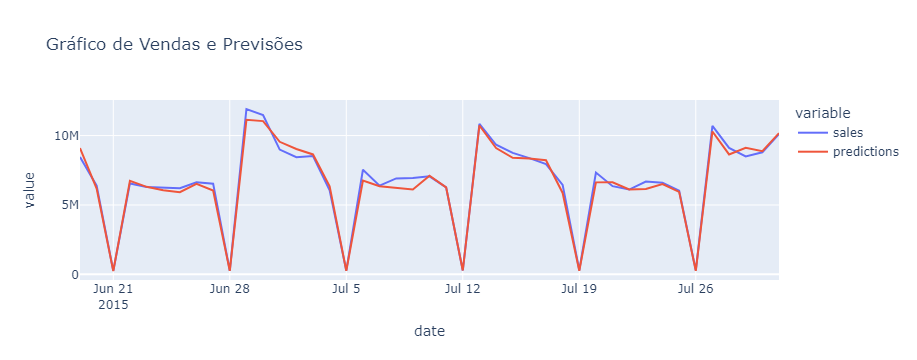

In [93]:
aux_compare_date = df9.loc[:, ['sales', 'predictions', 'date']].groupby('date').sum().reset_index()
px.line(aux_compare_date, x='date', y=['sales', 'predictions'], title = 'Gráfico de Vendas e Previsões')

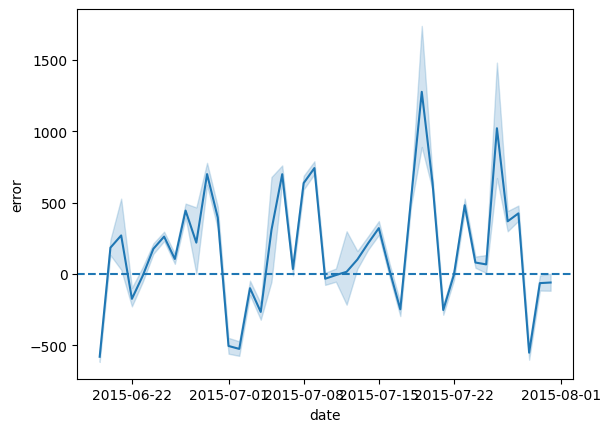

In [94]:
sns.lineplot(x='date', y='error', data=df9)
plt.axhline(1, linestyle='--')

<Axes: xlabel='error', ylabel='Density'>

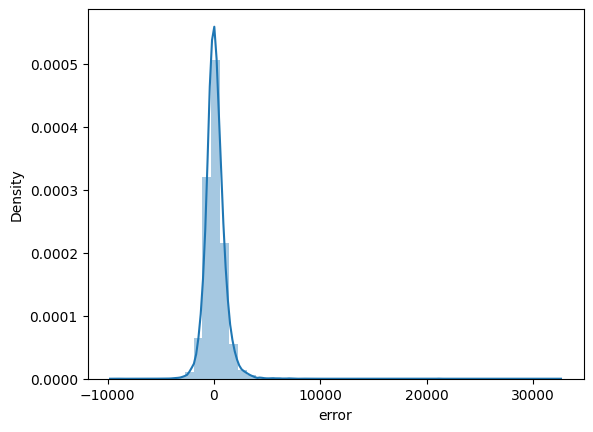

In [95]:
sns.distplot(df9['error'])

<Axes: xlabel='predictions', ylabel='error'>

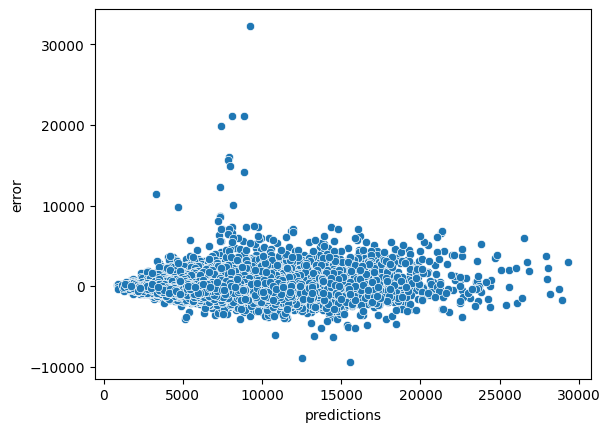

In [96]:
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# 10.0 Deploy Modelo em Produção

In [87]:

pickle.dump(model_xgb_tuned, open('../pickle/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [88]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/tfmeneghello/repos/ds_prod/'
        self.comp_distance_scaler = pickle.load(open(self.home_path + 'pickle/comp_distance_scaler.pkl', 'rb'))
        self.comp_timemonth_scaler = pickle.load(open(self.home_path + 'pickle/comp_timemonth_scaler.pkl', 'rb'))
        self.promo_timeweek_scaler = pickle.load(open(self.home_path + 'pickle/promo_timeweek_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'pickle/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'pickle/store_type_scaler.pkl', 'rb'))

    def data_cleaning( self, df1):
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        ## 1.3 Data types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        #competition_distance
        df1['competition_distance'] = [90000 if math.isnan(i) else i for i in df1['competition_distance']]

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                        x['competition_open_since_month'], axis = 1)
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                       x['competition_open_since_year'], axis = 1)            
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else
                                             x['promo2_since_week'], axis = 1) 
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else 
                                             x['promo2_since_year'], axis = 1)     
        #promo_interval  
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
        df1['promo_interval'] = df1['promo_interval'].fillna(0)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else
                                                                     1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1

    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year
        #month
        df2['month'] = df2['date'].dt.month
        #day
        df2['day'] = df2['date'].dt.day
        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        df2['week_of_year'] = df2['week_of_year'].astype(int)
        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                         month=x['competition_open_since_month'],
                                                                         day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1',
                                                                                           '%Y-%W-%w') - 
                                                                                            datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = ['basic' if i == 'a' else 'extra' if i == 'b' else 'extended' for i in df2['assortment']]

        #state_holiday
        df2['state_holiday'] = ['public_holiday' if i == 'a' else 'easter_holiday' if i == 'b' else 'christmas' if i == 'c' else 'regular_day' for i in df2['state_holiday']]

        ## 3.1 Filtragem das linhas
        df2 = df2.loc[df2['open'] != 0, :].reset_index()
        ## 3.2 Seleção das colunas
        cols_drop = ['open', 'month_map', 'promo_interval']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation( self, df5 ):
        df5['competition_distance'] = self.comp_distance_scaler.fit_transform(df5[['competition_distance']].values)
        df5['competition_time_month'] = self.comp_timemonth_scaler.fit_transform(df5[['competition_time_month']].values)
        df5['promo_time_week'] = self.promo_timeweek_scaler.fit_transform(df5[['promo_time_week']].values)
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformation
        #state_holiday - One Hot Encoding, bom para estado de coisas
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype='int64')

        #store_type - Label Encoding, bom para variáveis categóricas sem ordem ou relevância
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Encoding, bom para variáveis com intraordem.
        assort_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assort_dict)

        df5['sales'] = np.log1p(df5['sales'])

        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        cols_selected = ['store', 'promo','store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month','competition_open_since_year','promo2',
                         'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
                         'day_of_week_sin','day_of_week_cos','month_cos','month_sin','week_of_year_cos',
                         'week_of_year_sin','day_sin','day_cos']

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        # join pred into original date
        original_data['predictions'] = np.expm1(pred)

        return original_data.to_json( orient='records', date_format = 'iso')
 

## 10.2 API Handler

In [89]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/tfmeneghello/repos/ds_prod/pickle/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:   # there is data
        if isinstance(test_json, dict):      #unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:       # multiple data
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')


ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [176]:
df10 = pd.read_csv('../dataset/test.csv')
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

In [170]:
df_test['Store'].unique()

array([   1,    3,    7,    8,    9,   10,   11,   12,   13,   14,   15,
         16,   19,   20,   21,   22,   23,   24,   25,   27,   29,   30,
         31,   32,   33,   35,   36,   38,   39,   40,   41,   42,   43,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   56,   58,
         61,   62,   63,   64,   66,   67,   68,   69,   70,   71,   72,
         73,   74,   75,   76,   77,   79,   80,   81,   82,   83,   84,
         86,   89,   90,   91,   92,   93,   94,   98,   99,  100,  101,
        102,  105,  107,  108,  109,  110,  111,  112,  113,  115,  117,
        118,  119,  120,  122,  124,  126,  127,  128,  129,  130,  131,
        132,  135,  136,  137,  139,  140,  141,  142,  143,  144,  145,
        146,  147,  149,  150,  152,  153,  154,  155,  157,  158,  159,
        160,  161,  162,  164,  165,  166,  168,  169,  170,  171,  172,
        174,  175,  176,  179,  180,  181,  182,  183,  184,  186,  187,
        188,  189,  190,  191,  192,  193,  194,  1

In [177]:
df_test = df_test[df_test['Store'].isin([391, 406])]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test[df_test['Open'] != 0]
df_test = df_test.drop(['Id'], axis=1)

In [178]:
# convert dataframe to json
data = json.dumps( df_test.to_dict(orient='records'))

In [179]:
# calling API
#url = 'http://172.27.34.0:5000/rossmann/predict'
url = 'https://deploy-rossmann-sales-forecast.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )


print('Status-code: {}'.format(r.status_code))

Status-code: 200


In [180]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [181]:
d2 = d1.loc[:, ['store', 'predictions']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store n. {} tem previsão de R$ {:,.2f} em vendas nas próximas 6 semanas'.format(d2.loc[i,'store'], d2.loc[i,'predictions']))

Store n. 391 tem previsão de R$ 345,082.63 em vendas nas próximas 6 semanas
Store n. 406 tem previsão de R$ 267,327.54 em vendas nas próximas 6 semanas
